# Historical temperature mean climatology and biases from CMIP6 models


## Abstract

This notebook code computes and displays temperature climatology and mean bias for a, randomly selected, subset of [CMIP6](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections) global climate models (GCMs). The code aims to explore the capability of individual models and their ensemble mean as well as to reproduce the mean physical values during a historical period (1971-2005). The corresponding bias compared to the ECMWF reanalysis [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-complete?tab=doc) is also derived. 

Climate models are the primary tools for investigating the response of the climate system to various forcing, and for making climate predictions from seasonal to the coming century, and beyond, time scales. The objective of the CMIP6 initiative is to better understand past, present, and future climate change arising from natural, unforced variability or in response to changes in radiative forcing by means of a multi-model comparison. This latter is the key aspect to associate a level of uncertainty to any type of climate information you might enquiry climate models. Each model has its response (i.e., sensitivity) to the same forcing and subsequently, this defines a spectrum of plausible outcomes.

This notebook presents results for temperature mean climatology. The size and location of the subdomain considered are customizable, as well as the temporal aggregation (annual or seasonal). User can decide to mask or not ocean grid points.

## Analyses

This notebook performs the following analyses for the pr climate variable:
- maps of annual climatology of an ensemble of climate models compared to ERA5;
- maps of the corresponding mean biases for the climate models ensemble mean and for each specific model considered.
- a 1D plot of a statistical distribution built on the ensemble mean and model-specific spatial biases;
- verification statistics table, derived comparing simulations and ERA5 climatology;  
- [Taylor diagram](http://dx.doi.org/10.1029/2000JD900719) providing a statistical summary of how well-simulated simulations spatial patterns match reference data.


## Import packages

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import skill_metrics
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils

plt.style.use("seaborn-v0_8-notebook")

## Define parameters

In the "Define Parameters" section the customizable options of the notebook are set. These parameters consist of:
- the initial and ending year of the climatological analyses ('year_start' and 'year_stop').
- In the 'time series' parameter, we can set the temporal aggregation of climate data, in this case "annual" meaning that the entire year is considered instead of individual seasons.
- The 'Variable' parameter selects the variable to process. Temperature and precipitation available.
- 'collection_id' selects the climate simulations dataset consisting of a representative sub-set of the GCMs ensemble from CMIP6 and a sub-set of RCMs from the CORDEX initiative.
- For both types of climate models, we can choose to analyse a subdomain whose borders are selected by 'lon_slice' and 'lat_slice' parameters.
- Only for CORDEX simulations we can specify the different domains (e.g., europe, africa, north_america etc.) available through 'cordex_domain'. The selection of a region of analysis should be subsequently included within the CORDEX domain selected.
- 'chunk' selection allows to set the time length of data downloading and chunking in your local machine. It has not really effect on the analysis performed, so we suggest to keep the default value. 

In [2]:
# Time period
year_start = 1971
year_stop = 2000

# Choose annual or seasonal timeseries
timeseries = "annual"
assert timeseries in ("annual", "DJF", "MAM", "JJA", "SON")

# Variable
variable = "temperature"
assert variable in ("precipitation", "temperature")

# Choose CORDEX or CMIP6
collection_id = "CMIP6" 
assert collection_id in ("CORDEX", "CMIP6")

# Define region for analysis
lon_slice = slice(-180, 180)
lat_slice = slice(-90, 90)

# Define region for request
cordex_domain = "europe"

# Mask out sea grid nodes
mask_sea = True
assert isinstance(mask_sea, bool)

# Chunks for download
chunks = {"year": 1}
assert "month" not in chunks, "Do not use chunks smaller than 1y"

## Define models

The following climate analyses are performed considering a representative sub-set of RCMs from CORDEX and GCMs from CMIP6. Models names are listed in the parameters below. 

CMIP6 models can be chosen independently from the definition of parameters made in the cell above. To facilitate data download and processing, this notebook make use of CMIP6 models with coarse horizontal resolution. 

Cordex models selection has to accurately take into consideration the availability of RCMs for the selected GCM and the selected region. RCMs listed here are available for GCM “mpi_m_mpi_esm_lr” in the “europe” cordex_domain. Available combinations can be checked at confluence cordex webpage.

In [3]:
models_cordex = [
    "clmcom_clm_cclm4_8_17",
    "clmcom_eth_cosmo_crclim",
    "cnrm_aladin63",
    "dmi_hirham5",
    "knmi_racmo22e",
    "mohc_hadrem3_ga7_05",
    "mpi_csc_remo2009",
    "smhi_rca4",
    "uhoh_wrf361h",
]

models_cmip6 = [
    "cmcc_cm2_hr4",
    "mpi_esm1_2_lr",
    "access_cm2",
    "awi_esm_1_1_lr",
    "bcc_esm1",
    "cesm2_fv2",
    "cnrm_cm6_1",
    "fgoals_g3",
]

## Construct data request: ERA5

In this notebook, ERA5 is considered a reference product. In this section, we set the required parameters for the cds-api data-request of ERA5. 

In [4]:
era5_variables = {
    "precipitation": "mean_total_precipitation_rate",
    "temperature": "2m_temperature",
}

request_era = (
    "reanalysis-era5-single-levels-monthly-means",
    {
        "product_type": "monthly_averaged_reanalysis",
        "format": "netcdf",
        "time": "00:00",
        "variable": era5_variables[variable],
        "year": [
            str(year) for year in range(year_start - 1, year_stop + 1)
        ],  # Include D(year-1)
        "month": [f"{month:02d}" for month in range(1, 12 + 1)],
    },
)

request_lsm = (
    request_era[0],
    request_era[1] | {"year": "1940", "month": "01", "variable": "land_sea_mask"},
)

## Construct data request: climate models

In this section we set the required parameters for the cds-api data-request. The
function “get_cordex_years” is used to select appropriate chunks for the data request of CORDEX data. 

In [5]:
cordex_variables = {
    "precipitation": "mean_precipitation_flux",
    "temperature": "2m_air_temperature",
}

request_cordex = {
    "format": "zip",
    "domain": cordex_domain,
    "experiment": "historical",
    "horizontal_resolution": "0_11_degree_x_0_11_degree",
    "temporal_resolution": "monthly_mean",
    "variable": cordex_variables[variable],
    "gcm_model": "mpi_m_mpi_esm_lr",
    "ensemble_member": "r1i1p1",
}

cmip6_variables = {
    "precipitation": "precipitation",
    "temperature": "near_surface_air_temperature",
}
request_cmip6 = {
    "format": "zip",
    "temporal_resolution": "monthly",
    "experiment": "historical",
    "variable": cmip6_variables[variable],
    "year": request_era[1]["year"],
    "month": request_era[1]["month"],
}


def get_cordex_years(
    year_start,
    year_stop,
    start_years=[1971, 1981, 1991, 2001],
    end_years=[1980, 1990, 2000, 2005],
):
    start_year = []
    end_year = []
    years = set(range(year_start - 1, year_stop + 1))  # Include D(year-1)
    for start, end in zip(start_years, end_years):
        if years & set(range(start, end + 1)):
            start_year.append(start)
            end_year.append(end)
    return start_year, end_year


if collection_id.lower() == "cordex":
    periodic = False
    models = models_cordex
    model_key = "rcm_model"
    request_sim = (
        "projections-cordex-domains-single-levels",
        [
            {
                **request_cordex,
                "start_year": start_year,
                "end_year": end_year,
            }
            for start_year, end_year in zip(*get_cordex_years(year_start, year_stop))
        ],
    )
elif collection_id.lower() == "cmip6":
    periodic = True
    models = models_cmip6
    model_key = "model"
    request_sim = (
        "projections-cmip6",
        download.split_request(request_cmip6, chunks=chunks),
    )
else:
    raise ValueError

## Function to cache

In this notebook section are defined functions that will be executed in the caching phase.
Caching is the process of storing copies of files in a temporary storage location, so that they can be accessed more quickly. This procedure also recognises if a requested file have been already downloaded by the user, so that it is not necessary to perform the download again.

The function “compute_regridded_timeseries” aggregate data from monthly to annual resolution, regrid them to the specified output grid (ERA5 grid, in this case) and convert units. Attribute timeseries, set in Define parameter section, states if the analysis should be done on annual (‘annual’) or seasonal ( "DJF", "MAM", "JJA", "SON") values.


In [6]:
def compute_regridded_timeseries(
    ds, year_start, year_stop, timeseries, grid_out=None, **kwargs
):
    # Drop useless data
    if timeseries == "annual":
        mask = (ds["time"].dt.year >= year_start) & (ds["time"].dt.year <= year_stop)
    else:
        # Select years (shift -1 to get D(year-1)J(year)F(year))
        ds = ds.assign_coords(year=ds["time"].dt.year.shift(time=-1))
        mask = (
            (ds["year"] >= year_start)
            & (ds["year"] <= year_stop)
            & (ds["time"].dt.season == timeseries)
        )
    ds = ds.where(mask.compute(), drop=True)
    if not ds.sizes["time"]:
        # Return empty dataset. Previous year needed for DJF only.
        return xr.Dataset()

    # Select variable
    if var_names := set(ds.data_vars) & {"mtpr", "pr"}:
        field = "precipitation"
    elif var_names := set(ds.data_vars) & {"tas", "t2m"}:
        field = "temperature"
    else:
        raise ValueError("Unable to find precipitation or temperature variable.")
    (var_name,) = var_names
    da = ds[var_name].rename(field)

    # Create timeseries
    da = diagnostics.annual_weighted_mean(da)
    if timeseries != "annual":
        da = da.assign_coords(season=timeseries)

    # Regid
    if grid_out is not None:
        da = diagnostics.regrid(da, grid_out, **kwargs)

    # Convert units
    with xr.set_options(keep_attrs=True):
        if da.name == "precipitation":
            da *= 3600 * 24
            da.attrs["units"] = "mm/day"
        elif da.name == "temperature":
            da -= 273.15
            da.attrs["units"] = "°C"
            da = da.assign_coords(height=ds["height"] if "height" in ds else None)
        else:
            raise ValueError
    da.encoding["chunksizes"] = tuple(map(max, da.chunks))
    return da.to_dataset()

## Download and transform data

This section downloads model and reference data, transform them through the transform function “compute_regridded_timeseries”, and cache the results.

The output of this section, ds_era and ds_sim, contains respectively reference and multimodel data at annual resolution interpolated on the ERA5 grid.

In [7]:
transform_chunks = timeseries == "annual"
print("Downloading and processing ERA5")
ds_era = download.download_and_transform(
    *request_era,
    chunks=chunks,
    transform_chunks=transform_chunks,
    transform_func=compute_regridded_timeseries,
    transform_func_kwargs={
        "year_start": year_start,
        "year_stop": year_stop,
        "timeseries": timeseries,
    },
).expand_dims(model=["ERA5"])
ds_era = ds_era.chunk(year=chunks.get("year", -1))

datasets = []
for model in models:
    print(f"Downloading and processing {model}")
    request_model = request_sim
    for request in request_model[1]:
        request[model_key] = model
    ds = download.download_and_transform(
        *request_model,
        transform_chunks=transform_chunks,
        transform_func=compute_regridded_timeseries,
        transform_func_kwargs={
            "grid_out": ds_era[["longitude", "latitude"]],
            "year_start": year_start,
            "year_stop": year_stop,
            "timeseries": timeseries,
            "method": "bilinear",
            "periodic": periodic,
        },
    )
    datasets.append(ds.chunk(year=chunks.get("year", -1)).expand_dims(model=[model]))
ds_sim = xr.concat(datasets, "model")

100%|███████████████████████████████████████████| 31/31 [00:11<00:00,  2.67it/s]


100%|███████████████████████████████████████████| 31/31 [00:25<00:00,  1.24it/s]


100%|███████████████████████████████████████████| 31/31 [00:32<00:00,  1.04s/it]


100%|███████████████████████████████████████████| 31/31 [00:27<00:00,  1.11it/s]


100%|███████████████████████████████████████████| 31/31 [00:31<00:00,  1.01s/it]


100%|███████████████████████████████████████████| 31/31 [00:32<00:00,  1.04s/it]


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.31it/s]


100%|███████████████████████████████████████████| 31/31 [00:34<00:00,  1.10s/it]


100%|███████████████████████████████████████████| 31/31 [00:22<00:00,  1.38it/s]


## Create a single dataset and compute bias

This section computes multi-model ensemble mean, merge all values in a single dataset (ds_timeseries), cut them over the region of interest using utils.regionalise, compute climatology performing time average, mask out sea grid cells (if requested) and finally compute the bias of model values with respect to ERA5.

Output of this section are ds and ds_bias. ds contains climatological values, ds_bias contains the bias with respect to ERA5.


In [8]:
ensemble_name = f"{collection_id} ensemble"
ds_timeseries = xr.concat(
    [
        ds_sim.drop_vars("height", errors="ignore"),
        ds_sim.mean("model").expand_dims(model=[ensemble_name]),
        ds_era.drop_vars("height", errors="ignore"),
    ],
    "model",
)
ds_timeseries = utils.regionalise(
    ds_timeseries, lon_slice=lon_slice, lat_slice=lat_slice
)


ds = ds_timeseries.mean("year", keep_attrs=True)
if mask_sea:
    ds_lsm = download.download_and_transform(
        *request_lsm,
        transform_func=utils.regionalise,
        transform_func_kwargs={"lon_slice": lon_slice, "lat_slice": lat_slice},
    )
    da_lsm = ds_lsm["lsm"].squeeze("time", drop=True)
    ds = ds.where(da_lsm > 0.5)
ds = ds.compute()
with xr.set_options(keep_attrs=True):
    ds_bias = ds.drop_sel(model="ERA5") - ds.sel(model="ERA5")
for da in ds_bias.data_vars.values():
    da.attrs["long_name"] += " Bias"

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.68it/s]


## Results

## Plot Maps

This section plots maps that compare climatological values of the multi-model ensemble to climatological values of ERA5.

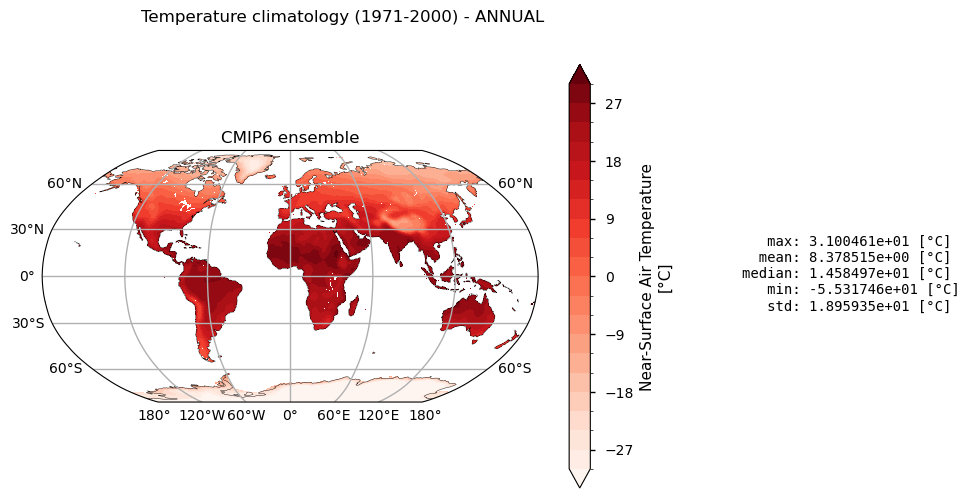

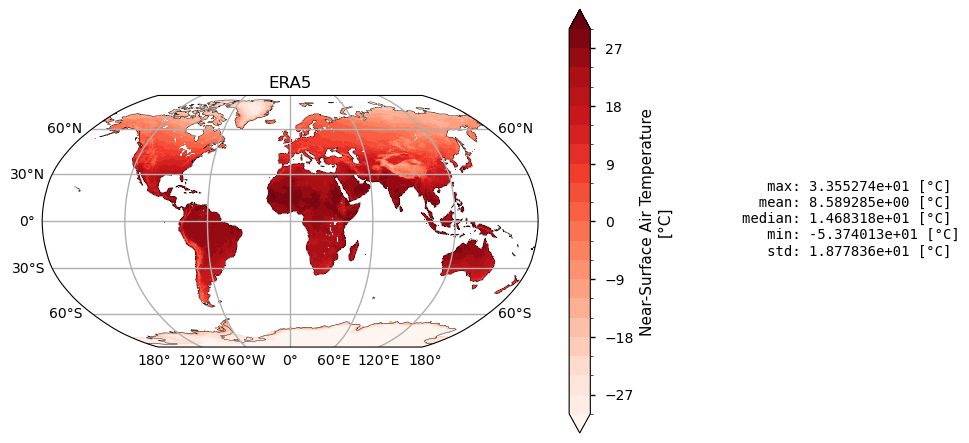

In [19]:
# Choose projection
is_global = (
    abs(lon_slice.stop - lon_slice.start) >= 360
    and abs(lat_slice.stop - lat_slice.start) >= 180
)

extent = (lon_slice.start, lon_slice.stop, lat_slice.start, lat_slice.stop)
Projection = ccrs.Robinson if is_global else ccrs.PlateCarree
projection = Projection(central_longitude=(lon_slice.stop + lon_slice.start) / 2)

da_to_plot = ds[variable].sel(model=[ensemble_name, "ERA5"])
plot_kwargs = xr.plot.utils._determine_cmap_params(
    da_to_plot.values,
    robust=True,
    levels=np.linspace(-30,30,21) if ((is_global) & (variable == "temperature")) else 10,
    cmap="Blues" if variable == "precipitation" else "Reds",
)
plot_kwargs["projection"] = projection

plt.suptitle(
    f"{variable.title()} climatology ({year_start}-{year_stop}) - {timeseries.upper()}"
)

for model, da_to_plot in da_to_plot.groupby("model"):
    plot.projected_map(
        da_to_plot,
        stats_weights=True,
        **plot_kwargs,
    )
    plt.title(model)
    plt.show()

Fig.1 A comparison between the mean annual values as simulated by the CMIP6 ensemble mean (upper panel) and produced by the reference product ERA5 (bottom panel)   

## Plot Bias

This section plot maps of bias for the multi-model ensemble (first panel) and for the single models (second panel). ERA5 is the reference dataset.

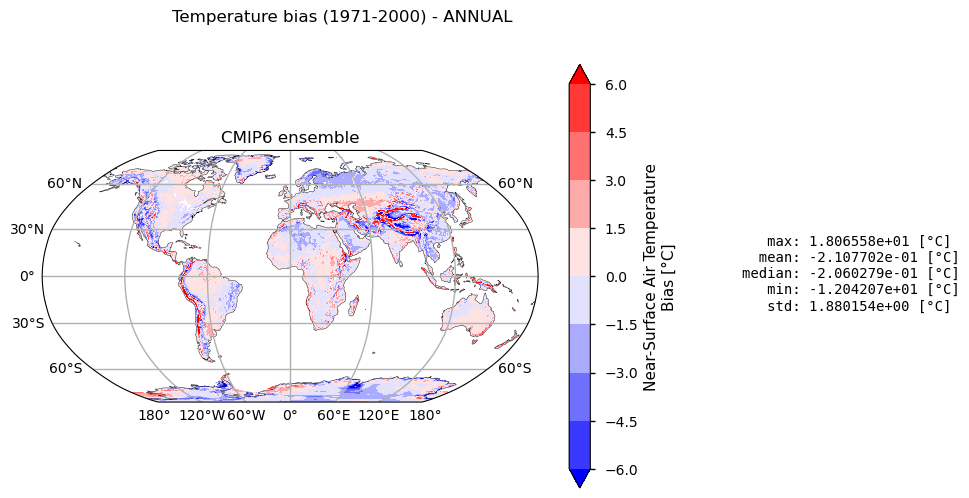

Text(0.5, 0.98, 'Temperature bias (1971-2000) - ANNUAL')

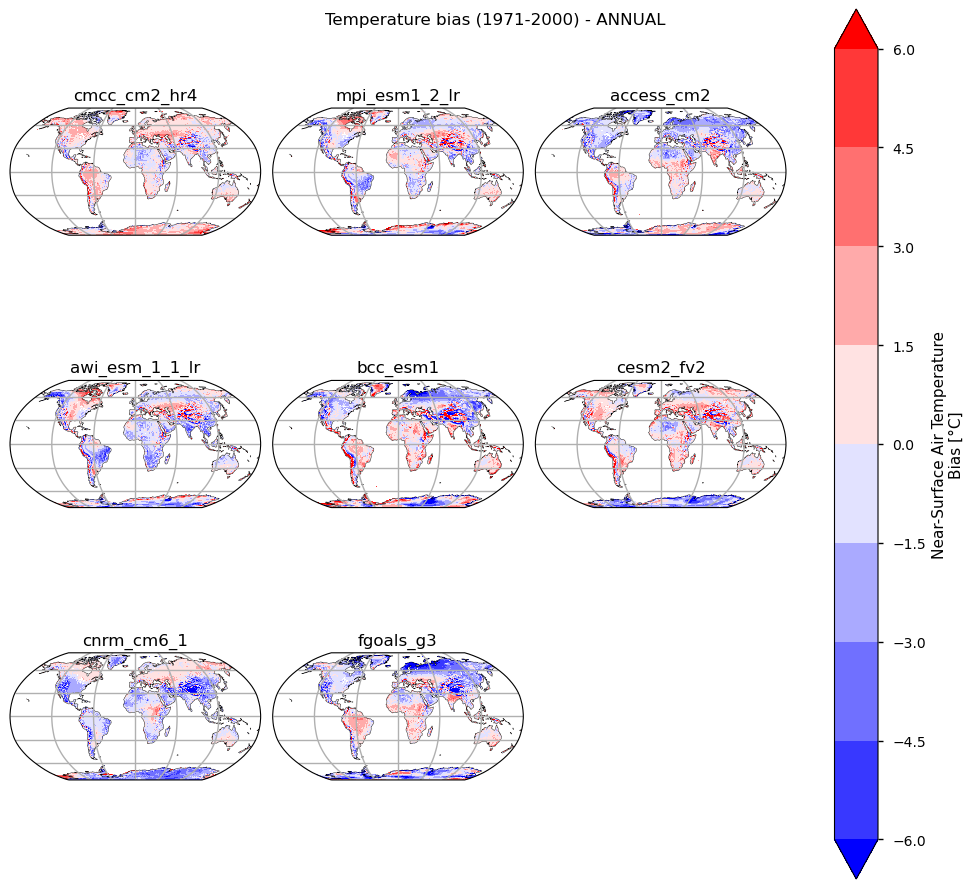

In [10]:
plot_kwargs = xr.plot.utils._determine_cmap_params(
    ds_bias[variable].values,
    robust=True,
    levels=11,
    cmap="bwr_r" if variable == "precipitation" else "bwr",
    center=0,
    extend="both",
)
plot_kwargs["projection"] = projection
plot.projected_map(
    ds_bias[variable].sel(model=ensemble_name), stats_weights=True, **plot_kwargs
)
plt.title(ensemble_name)
plt.suptitle(
    f"{variable.title()} bias ({year_start}-{year_stop}) - {timeseries.upper()}"
)

plt.show()
facet = plot.projected_map(
    ds_bias[variable].drop_sel(model=ensemble_name),
    col="model",
    col_wrap=min(3, ds_bias.sizes["model"] - 1),
    **plot_kwargs,
)
for i,ax in enumerate(facet.axs.flatten()[0:len(models)]):
    ax.set_global() if is_global else ax.set_extent(extent)
    ax.set_title(str(ds_bias[variable].drop_sel(model=ensemble_name).model[i].values))
    
plt.suptitle(
    f"{variable.title()} bias ({year_start}-{year_stop}) - {timeseries.upper()}"
)

Fig.2 CMIP6 annual mean bias from ERA5. The upper panel shows results for the multi-model ensemble mean whereas the bottom panels show results for individual models

## Plot KDE and Statistics of Bias

This section computes and plots the weighted kernel density estimation (KDE) of the bias distribution, for each model. For our purposes, the KDE is a way to describe the numerical distribution assumed by our spatial sample of bias values. 

Function diagnostics.spatial_weighted_statistics() compute spatial mean, median and standard deviation of the distribution of values.
Function scipy.stats.gaussian_kde() compute the KDE function.

Weights proportional to the cosine of latitude are applied in the calculation of statistics and of the KDE function to take into account different areas corresponding to grid cells at different latitudes.

Text(0.5, -0.25, ' KDE distribution of temperature bias fields (ANNUAL)  \n region: lon [-180, 180] x lat [-90, 90]')

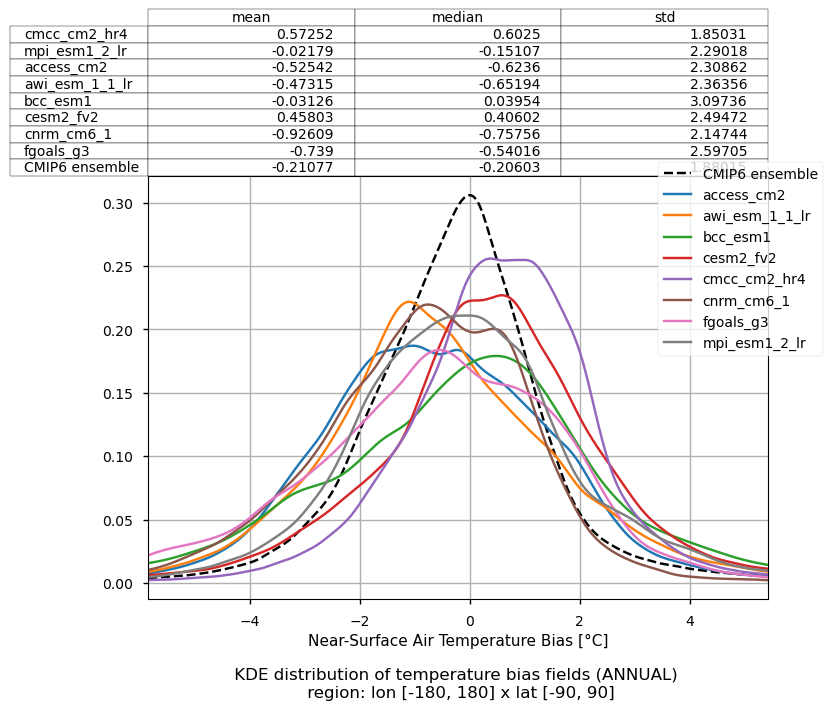

In [11]:
# Create dataframe
da = ds_bias[variable]
df_stats_bias = diagnostics.spatial_weighted_statistics(da, weights=True).to_pandas()

# Plot
fig, ax = plt.subplots(1, 1)
x = np.linspace(
    df_stats_bias[ensemble_name]["mean"] - 3 * df_stats_bias[ensemble_name]["std"],
    df_stats_bias[ensemble_name]["mean"] + 3 * df_stats_bias[ensemble_name]["std"],
    1_000,
)
for model, values in da.groupby("model"):
    values = values.stack(dim=values.dims).dropna("dim")
    y = scipy.stats.gaussian_kde(
        values,
        weights=np.abs(np.cos(np.deg2rad(values["latitude"]))),
    ).evaluate(x)
    plot_kwargs = {"color": "k", "ls": "--"} if model == ensemble_name else {}
    ax.plot(x, y, label=model, **plot_kwargs)
ax.grid()
ax.set_xlim(x[[0, -1]])
ax.set_xlabel(f"{da.attrs['long_name']} [{da.attrs['units']}]")
ax.legend(bbox_to_anchor=(1.1, 1.05))

# Add stats
table = plt.table(
    cellText=df_stats_bias.round(5).T.values.tolist(),
    colLabels=df_stats_bias.T.columns.values.tolist(),
    rowLabels=df_stats_bias.T.index.values.tolist(),
    loc="top",
)

plt.title((f" KDE distribution of {variable} bias fields ({timeseries.upper()})  \n region: lon [{lon_slice.start}, {lon_slice.stop}] x lat [{lat_slice.start}, {lat_slice.stop}]" ), y=-0.25)

Tab. 1 Bias statistics (mean, median, and standard deviation) for each model and ensemble mean considering all the grid nodes included in the region of interest 

Fig. 3 Statistical distribution of models and ensemble mean biases. The PDFs (Kernel Density Functions) are built considering grid node by grid node biases over the domain of interest 

## Compute verification statistics

To assess the accuracy of models in reproducing climatological values we compute the correlation, the root mean square error (RMSE) and the centered root mean square error (CRMSE) with respect to reference values.
These statistics, calculated using the function diagnostics.spatial_weighted_errors, appropriately consider the spatial weighting of data, as in the previous section.

The values are shown in the table below. Last column reports ensemble mean values.

In [12]:
df_error = diagnostics.spatial_weighted_errors(
    ds.drop_sel(model="ERA5"), ds.sel(model="ERA5"), weights=True
)[variable].to_pandas()
df_error

model,cmcc_cm2_hr4,mpi_esm1_2_lr,access_cm2,awi_esm_1_1_lr,bcc_esm1,cesm2_fv2,cnrm_cm6_1,fgoals_g3,CMIP6 ensemble
diagnostic,,,,,,,,,
corr,0.995264,0.992537,0.992771,0.992064,0.987276,0.991750,0.993623,0.992364,0.995082
crmse,1.850315,2.290183,2.308615,2.363558,3.097363,2.494718,2.147438,2.597052,1.880154
rmse,1.936864,2.290286,2.367651,2.410452,3.097521,2.536417,2.338617,2.700150,1.891931


Tab. 2 Spatial verification statistics (correlation, centered RMSE, and RMSE) of models and ensemble biases compared to ERA5 considering time averaged values over the domain of interest 

## Taylor Dyagram

The taylor diagram, plotted in this section, aims at giving an intuitive representation of the accuracy of models data in reproducing spatial patterns. 

The [Taylor diagram](https://pcmdi.llnl.gov/staff/taylor/CV/Taylor_diagram_primer.pdf) reports spatially averaged statistics (standard deviation, spatial correlation, and centred Root Mean Square Error (CRMSE)) of individual models and corresponding ensemble mean. It provides a statistical summary of how well-simulated spatial patterns match reference data in terms of correlation, centred root-mean-square difference and variances ratio ([Taylor 2011](http://dx.doi.org/10.1029/2000JD900719)).

The three statics summarized have been applied to spatial fields of trend values (2D matrices)  and can be considered informative about the following aspects: 
- CRMSE is defined as the Root Mean Square Error between model and reference fields after the removal of the mean value of each field. It can be thought of as quantifying the capability of the models to reproduce physical values, once the mean error has been removed.
- (Spatial) Correlation. Reproducibility of the spatial pattern of the climate variable.
- Standard deviation. Reproducibility of the spatial variability of the climate variable.

PLEASE NOTE: the means of the fields are subtracted out before computing the three statistics (see [link](https://pcmdi.llnl.gov/staff/taylor/CV/Taylor_diagram_primer.pdf)), so the diagram does not provide information about overall biases, but solely characterizes the centered pattern error. 

 Taylor diagram for annual temperature mean climatology 
 region: lon [-180, 180] x lat [-90, 90]


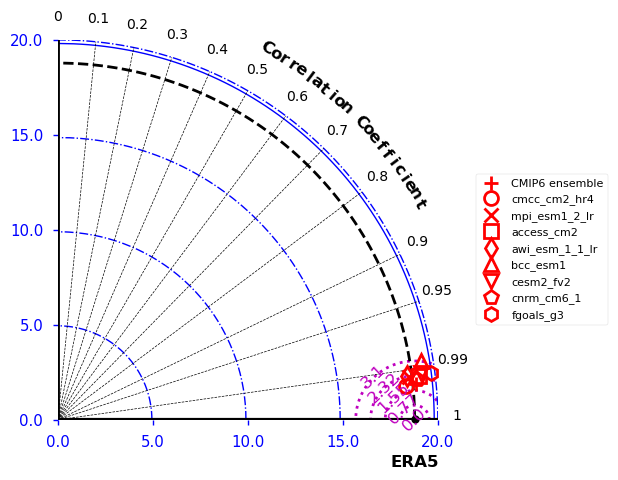

In [13]:
df_stats = diagnostics.spatial_weighted_statistics(ds, weights=True)[variable].to_pandas()
df_stats_and_error = pd.concat([df_stats, df_error])
df_stats_and_error = df_stats_and_error.reindex(columns=["ERA5", ensemble_name] + models)
tickRMS = np.linspace(0, df_stats_and_error.loc["crmse"].max(), 5).round(2)
tickSTD = np.linspace(0, df_stats_and_error.loc["std"].max(), 5).round(2)

skill_metrics.taylor_diagram(
    df_stats_and_error.loc["std"].values,
    df_stats_and_error.loc["crmse"].values,
    df_stats_and_error.loc["corr"].values,
    alpha=0.0,
    colCOR="k",
    colOBS="k",
    colRMS="m",
    colSTD="b",
    markerColor="r" if len(df_stats_and_error.columns) >= 9 else None,  # TODO
    markerLabel=list(df_stats_and_error.columns),
    markerLegend="on",
    markerSize=10,
    markerobs="o",
    styleCOR="--",
    styleOBS="--",
    styleRMS=":",
    styleSTD="-.",
    tickRMS=tickRMS,
    tickSTD=tickSTD,
    titleCOR="on",
    titleOBS="ERA5",
    titleRMS="off",
    titleRMSDangle=40.0,
    titleSTD="off",
    widthCOR=0.5,
    widthOBS=2,
    widthRMS=2,
    widthSTD=1.0,
)

print(f' Taylor diagram for {timeseries} {variable} mean climatology \n region: lon [{lon_slice.start}, {lon_slice.stop}] x lat [{lat_slice.start}, {lat_slice.stop}]' )

Fig. 4 [Taylor diagram](https://pcmdi.llnl.gov/staff/taylor/CV/Taylor_diagram_primer.pdf) reporting spatially averaged statistics (standard deviation, spatial correlation, and centred Root Mean Square Error) for climatology maps of individual models and corresponding ensemble mean. Blue semicircles are  isolines of standard deviation of the fields. Purple semicircles are isolines of CRMSE with respect to ERA5.

## Main results

The CMIP6 ensemble mean is able to reproduce the 2m air temperature spatial pattern with high accuracy, except for region of complex orography, where their coarse resolution does not allow to capture the local scale variability of the field. For this reason, we observe largest bias over highest mountain ranges like the Andes, the Rocky Mountains  and Himalaya. However, coarse resolution GCMs are not intended to resolve such high spatial variability, so the main focus of the assessment should fall on large scale bias.

Single models results show that models can have large temperature bias also over vaste areas. For example 4 out of 8 models show cold bias over Antartica. 3 over 8 shows large bias over northern Russia. Such bias are slightly compensated in the ensemble mean, but still emerge.

Root mean square error of the ensemble mean is 1.89 °C. The single models RMSEs fall approximately in the range 1.9 - 3.1 °C. Then, in terms of RMSE the ensemble mean is the most accurate product in this case, performing better than any single model.

According to the Taylor diagram results, we can notice GCMs are mainly characterised by:
- a good capability by models to reproduce the observed large scale spatial patterns (spatial correlation about 0.99)
- Good performances among GCMs in reproducing the reference (ERA5) temperature spatial variability (standard deviation of the field).


 ## Final remarks

Large bias in the historical period does not necessarily mean 'low quality' of climate simulations but rather an intrinsic limit of the still coarse resolution GCMs in reproducing complex-orography. 

GCMs represent a tool idealized to study the response of general circulation dynamics to an increased greenhouse gasses concentration. We do not advocate for direct use of GCM outputs if regional-to-local scale information is sought (e.g., driving hydrological, agricultural, or wind power modeling tools) or changes in extremes (wind storms or heatwaves) at such fine scales.